In [1]:
import MKLpy
import pandas as pd
import numpy as np
import sklearn.svm as svm
import pickle
import os

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import KFold, cross_val_score
from sklearn.multiclass import OneVsRestClassifier  # support from multiclass
scaler = StandardScaler()
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict
import matplotlib.pyplot as plt
from MKLpy.preprocessing import normalization, rescale_01
from MKLpy.model_selection import cross_val_score, cross_val_predict

In [2]:
def open_pickle_file(path, pickle_file):
    file_loc = os.path.join(path, pickle_file)
    pickle_to_file = pickle.load(open(file_loc, "rb"))
    return pickle_to_file
def checkDir(dirLoc):
    print
    if os.path.exists(dirLoc):#Checks if the dir exists
        print("The directory exists")
    else:
        print ("No directory found for "+dirLoc) #Output if no directory
#         print
#         os.makedirs(CheckDir)#Creates a new dir for the given name
#         print "Directory created for "+CheckDir

In [3]:
dataOnlyDrive = '/media/ak/DataOnly'  # external date only drive
#ext_drive_loc = ('/media/ak/My Passport/Experiment Data/')
data_dir = os.getenv('FINANCE_DATA') #internal folder with finance data 
folderList =  [s for s in os.listdir(dataOnlyDrive) if s.startswith('Dat') or s.startswith('Fin')]
# inputDrive = data_only_drive
# features = os.path.join(inputDrive,'features')
# labels = os.path.join(inputDrive, 'labels')

# symbols = [s for s in os.listdir(features) if s.endswith('.L')]
folderIdx = 0
finalLocation= "/".join((dataOnlyDrive,folderList[folderIdx]))
symbols = [s for s in os.listdir(finalLocation) if s.endswith('.L')] #keep a list of the symbols
os.listdir(finalLocation)

['CNA.L', 'PRU.L', 'Labels', 'REL.L', 'BARC.L']

In [4]:
folderList

['FinDataReal', 'FinData', 'Data']

## pick a symbol ## 

In [5]:
##picking up a specific feature
symbolIdx = 1 #pick one of the symbols
#symbols[symbolIdx] -->output :PRU.L
print(symbols[symbolIdx])
# do a join to get the location
symbolLocation = "/".join((finalLocation,symbols[symbolIdx])) 

# get he features now
symbolFeaturesLocation = "/".join((symbolLocation,'MODEL_BASED')) # where all the HMM output is

print(symbolFeaturesLocation) # <-- all the HMM model output is here, for each model there is a Date Folder and then OOS files

PRU.L
/media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED


### pick Features for a specific HMM MODEL Date ###
### then move to labels ...pick the location of the labels and make a list of all the available labels ##

In [18]:

symbolHMMDatesList = os.listdir(symbolFeaturesLocation) 

#list of all the MODEL dates we have generated features files for. each #
# each of these dates in symbolFeaturesDates corresponds to a list of dates
## (symbolHMMDatesList = '20170829', '20170710', '20170801', ... ]
#location of labels : /media/ak/DataOnly/FinDataReal/Labels/[Symbol :PRU.L]/NON_DIRECTIONAL

symbolLabelsLocation = "/".join((finalLocation, 'Labels',symbols[symbolIdx],'NON_DIRECTIONAL')) 

#list of all the label dates

symbolLabelsDates =[dateFile.split(".")[0] for dateFile in os.listdir(symbolLabelsLocation)]

# Output symbolLabelsDates --> ['20170704', '20180226', '20180208',...] all we are doing is going for this 
symbolFeaturesLocation


'/media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED'

array(['20170116', '20170117', '20170118', '20170119', '20170120',
       '20170123', '20170124', '20170125', '20170126', '20170127',
       '20170130', '20170131', '20170301', '20170703', '20170704',
       '20170705', '20170706', '20170707', '20170710', '20170711',
       '20170712', '20170713', '20170714', '20170717', '20170718',
       '20170719', '20170720', '20170721', '20170724', '20170725',
       '20170726', '20170727', '20170728', '20170731', '20170801',
       '20170802', '20170803', '20170804', '20170807', '20170808',
       '20170809', '20170810', '20170811', '20170814', '20170815',
       '20170816', '20170817', '20170818', '20170821', '20170822',
       '20170823', '20170824', '20170825', '20170829', '20170830',
       '20170831', '20180201', '20180202', '20180205', '20180206',
       '20180207', '20180208', '20180209', '20180212', '20180213',
       '20180214', '20180215', '20180216', '20180219', '20180220',
       '20180221', '20180222', '20180223', '20180226', '201802

In [22]:
##now lets go down into each HMM-model date, and pick all the forward futures (out of sample)
hmmFeatureLocations ={} #symbol-hmm-model-date index --> this is the indexation in symbolFeaturesDatesList
commonDatesDict ={} # this is a struct that will contain for each HMM date, the common labels/features- this should be used for training and testing
createDate =[] #place holder for the hash key of when the features got created
commonFeaturesLocs ={}
commonLabelsLocs ={}
commonLocs ={}

#this symbolFeaturesDatesList[featrsIdx] will give you a date: 20170710 =which contains all the HMM induced featureb
for hmmDateIdx, hmmDate in enumerate(np.sort(symbolHMMDatesList)):
    
    symbolModelFeaturesDate = "/".join((symbolFeaturesLocation, symbolHMMDatesList[hmmDateIdx]))
    createDate = os.listdir(symbolModelFeaturesDate)[2].split("_")[7] #stupid hack

    #output looks like this: /media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED/20170710
    symbolEachModelFeaturesDates=[file.split("_")[5] for file in os.listdir(symbolModelFeaturesDate )] 
    #output is a list of dates

    commonDates =list(set(symbolEachModelFeaturesDates) & set(symbolLabelsDates)) # this is a list of features and labels dates
    
    for commonDate in np.sort(commonDates):
        print("create Date:###",createDate)
        print("common Date:-----", commonDate)
        labelsCommonDateFile = ".".join((commonDate,'csv'))
        labelsCommonFileLoc = "/".join((symbolLabelsLocation, labelsCommonDateFile))
        labelsDf=pd.read_csv(labelsCommonFileLoc)
        comnDateFeatureLocMaster =("/".join((symbolFeaturesLocation, hmmDate)))
        commonDatesFeatureFile = "".join((symbols[1],'_3_states_features_date:_',commonDate,"_now:_",createDate,"_.pickle"))
        FeatureFileLoc = "/".join((comnDateFeatureLocMaster,commonDatesFeatureFile))
       
        commonLocs[commonDate]=[FeatureFileLoc,labelsCommonFileLoc ]
        print(commonLocs[commonDate])



create Date:### 20181229
common Date:----- 20170830
['/media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED/20170116/PRU.L_3_states_features_date:_20170830_now:_20181229_.pickle', '/media/ak/DataOnly/FinDataReal/Labels/PRU.L/NON_DIRECTIONAL/20170830.csv']
create Date:### 20181229
common Date:----- 20170831
['/media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED/20170116/PRU.L_3_states_features_date:_20170831_now:_20181229_.pickle', '/media/ak/DataOnly/FinDataReal/Labels/PRU.L/NON_DIRECTIONAL/20170831.csv']
create Date:### 20181229
common Date:----- 20180201
['/media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED/20170116/PRU.L_3_states_features_date:_20180201_now:_20181229_.pickle', '/media/ak/DataOnly/FinDataReal/Labels/PRU.L/NON_DIRECTIONAL/20180201.csv']
create Date:### 20181229
common Date:----- 20180202
['/media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED/20170116/PRU.L_3_states_features_date:_20180202_now:_20181229_.pickle', '/media/ak/DataOnly/FinDataReal/Labels/PRU.L/NON_DIRECTIONAL/20180202.cs

common Date:----- 20180214
['/media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED/20170705/PRU.L_3_states_features_date:_20180214_now:_20181229_.pickle', '/media/ak/DataOnly/FinDataReal/Labels/PRU.L/NON_DIRECTIONAL/20180214.csv']
create Date:### 20181229
common Date:----- 20180215
['/media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED/20170705/PRU.L_3_states_features_date:_20180215_now:_20181229_.pickle', '/media/ak/DataOnly/FinDataReal/Labels/PRU.L/NON_DIRECTIONAL/20180215.csv']
create Date:### 20181229
common Date:----- 20180216
['/media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED/20170705/PRU.L_3_states_features_date:_20180216_now:_20181229_.pickle', '/media/ak/DataOnly/FinDataReal/Labels/PRU.L/NON_DIRECTIONAL/20180216.csv']
create Date:### 20181229
common Date:----- 20180219
['/media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED/20170705/PRU.L_3_states_features_date:_20180219_now:_20181229_.pickle', '/media/ak/DataOnly/FinDataReal/Labels/PRU.L/NON_DIRECTIONAL/20180219.csv']
create Date:### 20181

IndexError: list index out of range

### Training Set ###

In [23]:
keys =list(commonLocs.keys())
idxKey=0
featuresIdxDirFileLoc= commonLocs[keys[idxKey]][0]
labelsIdxDirFileLoc= commonLocs[keys[idxKey]][1]  
featuresTupleFile = pickle.load(open(featuresIdxDirFileLoc,"rb"), encoding='latin1')   
labelsDf=pd.read_csv(labelsIdxDirFileLoc)

In [80]:
## printing files we are loading -Dates should match ##
for i in range(3):
    print(i)

0
1
2


In [129]:
from MKLpy.preprocessing import normalization, rescale_01
from MKLpy.metrics import pairwise
from MKLpy.algorithms import AverageMKL, EasyMKL, KOMD#KOMD is not a MKL algorithm but a simple kernel machine like the SVM
#evaluate the solution
from sklearn.metrics import accuracy_score, roc_auc_score 
#for idxKey, commonDate in #enumerate(commonLocs.keys()):
for idxKey in range(13):
    
    featuresIdxDirFileLoc= commonLocs[keys[idxKey]][0]
    labelsIdxDirFileLoc= commonLocs[keys[idxKey]][1]  
    
    featuresTupleFile = pickle.load(open(featuresIdxDirFileLoc,"rb"), encoding='latin1')   
    labelsDf=pd.read_csv(labelsIdxDirFileLoc)
    
    dfFeatures = pd.concat([featuresTupleFile[0], featuresTupleFile[1],\
                                                 featuresTupleFile[2], featuresTupleFile[3]], axis=1, sort=False).fillna(0)
    #take the labels out
    labels =labelsDf['label_PrMov__window_5__thres_arbitrary__0.1'] 
    print ('preprocessing data...', end='')
    dfXY = pd.concat([dfFeatures, labels], axis=1, sort='False').dropna()
    labelName = str(dfXY.columns[dfXY.columns.str.contains(pat='label')].values[0])
    dfX = dfXY.drop(columns=[ labelName])
    print("Shape of dfX..",dfX.shape[0])   
    arrX = np.array(dfX)
    X = rescale_01(arrX) #feature scaling in [0,1]
    X = normalization(rescale_01(arrX))
    print (X.shape,'done')
    y = dfXY[dfXY.columns[dfXY.columns.str.contains(pat='label')]].iloc[:, 0]
    print("Shape of y..", y.shape)
    Xtr,Xte,Ytr,Yte = train_test_split(X,y, test_size=.55, random_state=42)
    #compute homogeneous polynomial kernels with degrees 0,1,2,...,10.
    print ('computing Homogeneous Polynomial Kernels...', end='')
    KLtr = [pairwise.homogeneous_polynomial_kernel(Xtr, degree=d) for d in range(4)]
    KLte = [pairwise.homogeneous_polynomial_kernel(Xte,Xtr, degree=d) for d in range(4)]
    from sklearn.metrics.pairwise import rbf_kernel
    gamma_range = np.logspace(-9, 3, 13)
    ker_list = [rbf_kernel(Xtr, gamma=g) for g in gamma_range]
    print ('RBF Kernels done')
    ### test set work ###
    KLtest = [pairwise.homogeneous_polynomial_kernel(TestX,Xtr, degree=d) for d in range(4)]
    from sklearn.metrics.pairwise import rbf_kernel
    gamma_range = np.logspace(-9, 3, 13)
    ker_list = [rbf_kernel(Xtr, gamma=g) for g in gamma_range]
    print ('training AverageMKL...', end='')
    clf = AverageMKL().fit(KLtr,Ytr) #a wrapper for averaging kernels
    print ('done')
    print(clf.weights) #print the weights of the combination of base kernels
    print ('training EasyMKL...', end='')
    clfEasy = EasyMKL(lam=0.1).fit(KLtr,Ytr)#combining kernels with the EasyMKL algorithm
    clfRBF = EasyMKL(lam=0.1).fit(ker_list,Ytr)
    #lam is a hyper-parameter in [0,1]
    print ('done')
    print (clfEasy.weights)
    print('Linear')
    y_pred = clf.predict(KLte)                 #predictions
    y_score = clf.decision_function(KLte)      #rank
    accuracy = accuracy_score(Yte, y_pred)
    roc_auc = roc_auc_score(Yte, y_score)
    print ('Accuracy score: %.3f, roc AUC score: %.3f' % (accuracy, roc_auc))
    print('MKL-Linear')
    y_predTest = clfEasy.predict(KLte)                 #predictions
    y_scoreTest = clfEasy.decision_function(KLte)      #rank
    accuracy = accuracy_score(Yte, y_predTest)
    roc_auc = roc_auc_score(Yte, y_scoreTest)
    print ('Accuracy score: %.3f, roc AUC score: %.3f' % (accuracy, roc_auc))
    print('MKL-RBF')
    y_predRBF = clfRBF.predict(KLte)                 #predictions
    y_scoreRBF = clfRBF.decision_function(KLte)      #rank
    accuracyRBF = accuracy_score(Yte, y_predRBF)
    roc_aucRBF = roc_auc_score(Yte, y_scoreRBF)
    print ('Accuracy score: %.3f, roc AUC score: %.3f' % (accuracyRBF, roc_aucRBF))
 
    
    

preprocessing data...Shape of dfX.. 2222
(2222, 21) done
Shape of y.. (2222,)
computing Homogeneous Polynomial Kernels...RBF Kernels done
training AverageMKL...done
[0.25 0.25 0.25 0.25]
training EasyMKL...done
[4.24712541e-17 8.31875598e-02 2.27802874e-01 6.89009566e-01]
Linear
Accuracy score: 0.990, roc AUC score: 0.641
MKL-Linear
Accuracy score: 0.903, roc AUC score: 0.839
MKL-RBF
Accuracy score: 0.992, roc AUC score: 0.841
preprocessing data...Shape of dfX.. 2963
(2963, 21) done
Shape of y.. (2963,)
computing Homogeneous Polynomial Kernels...RBF Kernels done
training AverageMKL...done
[0.25 0.25 0.25 0.25]
training EasyMKL...done
[-4.41831877e-24  7.64806718e-02  2.63343650e-01  6.60175678e-01]
Linear
Accuracy score: 0.992, roc AUC score: 0.820
MKL-Linear
Accuracy score: 0.980, roc AUC score: 0.875
MKL-RBF
Accuracy score: 0.991, roc AUC score: 0.878
preprocessing data...Shape of dfX.. 4517
(4517, 21) done
Shape of y.. (4517,)
computing Homogeneous Polynomial Kernels...RBF Kernels d

### Test Set ###

In [84]:
testKey=1
if testKey != idxKey:
    testFeaturesIdxDirFileLoc= commonLocs[keys[testKey]][0]
    testLabelsIdxDirFileLoc= commonLocs[keys[testKey]][1]
    testFeaturesTupleFile = pickle.load(open(testFeaturesIdxDirFileLoc,"rb"), encoding='latin1')   
    testLabelsDf=pd.read_csv(testLabelsIdxDirFileLoc)
else:
    print('you have same dates')

### pick up the train features ###

In [85]:

dfFeatures = pd.concat([featuresTupleFile[0], featuresTupleFile[1],\
                                                 featuresTupleFile[2], featuresTupleFile[3]], axis=1, sort=False).fillna(0)

In [86]:
#take the labels out
labels =labelsDf['label_PrMov__window_5__thres_arbitrary__0.1'] 

labelsShift = labels.isna().sum() # going to use this for "allignment of features and labels"
labelsShift

4

### pick up the test-features ###

In [87]:

dfTestFeatures = pd.concat([testFeaturesTupleFile [0], testFeaturesTupleFile[1],\
                                                 testFeaturesTupleFile[2], testFeaturesTupleFile[3]], axis=1, sort=False).fillna(0)

In [88]:
#take the labels out
testLabels =testLabelsDf['label_PrMov__window_5__thres_arbitrary__0.1'] 

testLabelsShift = testLabelsDf.isna().sum() # going to use this for "allignment of features and labels"


### put labels and features together before you dropnans -train/test###

In [89]:

dfXY = pd.concat([dfFeatures, labels], axis=1, sort='False').dropna()
labelName = str(dfXY.columns[dfXY.columns.str.contains(pat='label')].values[0])

In [90]:

dfTestXY = pd.concat([dfTestFeatures, testLabels], axis=1, sort='False').dropna()
testLabelName = str(dfTestXY.columns[dfTestXY.columns.str.contains(pat='label')].values[0])

## get working now on features and labels for MKL ##

In [91]:
dfX = dfXY.drop(columns=[ labelName])
print("Shape of dfX..",dfX.shape[0])    
dfX.columns.values


Shape of dfX.. 4517


array(['fischer_score_dlambda', 'fischer_score_dsigma',
       'fischer_score_dweight', 'lambda_lambda', 'lambda_sigma',
       'lambda_weight', 'sigma_sigma', 'sigma_weight', 'weight_weight',
       'gamma_0', 'gamma_1', 'gamma_2', 'ksi_0_to_0', 'ksi_0_to_1',
       'ksi_0_to_2', 'ksi_1_to_0', 'ksi_1_to_1', 'ksi_1_to_2',
       'ksi_2_to_0', 'ksi_2_to_1', 'ksi_2_to_2'], dtype=object)

In [119]:
# dfTestX = dfTestXY.drop(columns=[ labelName])
# print("Shape of dfTestX..",dfTestX.shape[0])    
# dfTestX.columns.values==dfX.columns.values

## split the data + standarise ##

In [120]:
X =StandardScaler().fit_transform(dfX)
y = dfXY[dfXY.columns[dfXY.columns.str.contains(pat='label')]].iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [121]:
print(X.shape, y.shape)

(4517, 21) (4517,)


In [94]:
# testX = StandardScaler().fit_transform(dfTestXY)
# testY = dfTestXY[dfTestXY.columns[dfTestXY.columns.str.contains(pat='label')]].iloc[:, 0]

## Simple Classifiers for Comparison ##

### Trying MKL for the very first time ###

In [122]:
#preprocess data
print ('preprocessing data...', end='')
from MKLpy.preprocessing import normalization, rescale_01
arrX = np.array(dfX)
X = rescale_01(arrX) #feature scaling in [0,1]
X = normalization(rescale_01(arrX))
Y=y
print(X.shape, y.shape)
# ## test set
# arrTestX = np.array(dfTestX)
# TestX = rescale_01(arrTestX) #feature scaling in [0,1]
# TestX = normalization(rescale_01(arrTestX))
# TestY=testY

preprocessing data...(4517, 21) (4517,)


### splitting the date into training and testing ###

In [96]:
Xtr,Xte,Ytr,Yte = train_test_split(X,Y, test_size=.55, random_state=42)
print (X.shape,'done')

(4517, 21) done


In [97]:
#compute homogeneous polynomial kernels with degrees 0,1,2,...,10.
print ('computing Homogeneous Polynomial Kernels...', end='')

from MKLpy.metrics import pairwise
KLtr = [pairwise.homogeneous_polynomial_kernel(Xtr, degree=d) for d in range(4)]
KLte = [pairwise.homogeneous_polynomial_kernel(Xte,Xtr, degree=d) for d in range(4)]
from sklearn.metrics.pairwise import rbf_kernel
gamma_range = np.logspace(-9, 3, 13)
ker_list = [rbf_kernel(Xtr, gamma=g) for g in gamma_range]
print ('RBF Kernels done')
### test set work ###
KLtest = [pairwise.homogeneous_polynomial_kernel(TestX,Xtr, degree=d) for d in range(4)]
from sklearn.metrics.pairwise import rbf_kernel
gamma_range = np.logspace(-9, 3, 13)
ker_list = [rbf_kernel(Xtr, gamma=g) for g in gamma_range]


computing Homogeneous Polynomial Kernels...RBF Kernels done


In [98]:
#clf.fit(X_train, y_train)
classifier = SVC(kernel='linear', C=0.01)
linear_clf=classifier.fit(Xtr, Ytr)
# Create a SVC classifier using an RBF kernel
rbf_classifier= SVC(kernel='rbf', random_state=0, gamma=1000, C=1000)
rbf_clf=rbf_classifier.fit(Xtr, Ytr)

In [99]:
#MKL algorithms
from MKLpy.algorithms import AverageMKL, EasyMKL, KOMD#KOMD is not a MKL algorithm but a simple kernel machine like the SVM
print ('training AverageMKL...', end='')
clf = AverageMKL().fit(KLtr,Ytr) #a wrapper for averaging kernels
print ('done')
print(clf.weights) #print the weights of the combination of base kernels
K_average = clf.ker_matrix #the combined kernel matrix

training AverageMKL...done
[0.25 0.25 0.25 0.25]


In [100]:
# clfRBF = clf = AverageMKL().fit(ker_list,Ytr) #a wrapper for averaging kernels
K_average_rbf = clfRBF.ker_matrix

In [101]:
dfKaverage =pd.DataFrame(K_average)
dfKaverageRBF =pd.DataFrame(K_average_rbf)


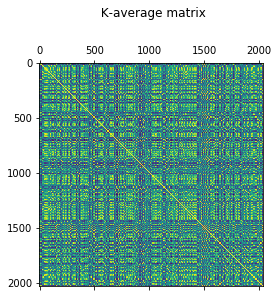

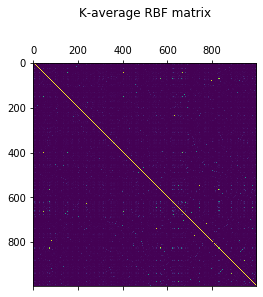

In [102]:

_=plt.matshow(dfKaverage, fignum=100)
plt.gca().set_aspect('auto')
plt.title(' K-average matrix' ,y=1.18)
plt.show()
plt.matshow(dfKaverageRBF, fignum=100)
plt.gca().set_aspect('auto')
_=plt.title('K-average RBF matrix', y=1.18)
plt.show()

In [103]:
print ('training EasyMKL...', end='')
clf = EasyMKL(lam=0.1).fit(KLtr,Ytr)#combining kernels with the EasyMKL algorithm
clfEasyRBF = EasyMKL(lam=0.1).fit(ker_list,Ytr)
#lam is a hyper-parameter in [0,1]
print ('done')
print (clf.weights)

training EasyMKL...done
[4.05668870e-26 9.60476239e-02 2.85788061e-01 6.18164315e-01]


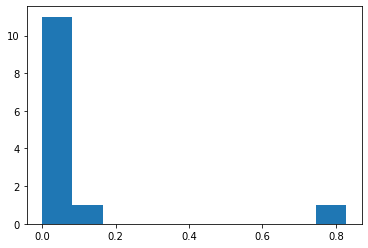

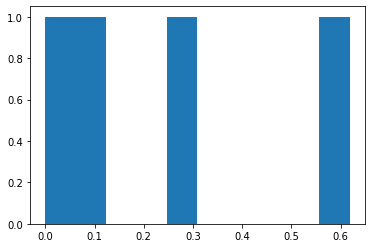

In [104]:
_=plt.hist(clfEasyRBF.weights)
plt.show()
_=plt.hist (clf.weights)

In [105]:
dfWeights =pd.DataFrame()

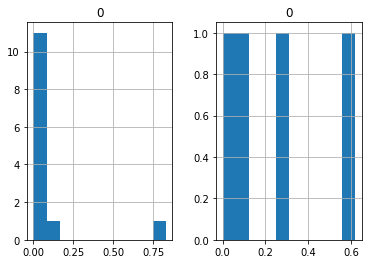

In [106]:
dfweights = pd.DataFrame(clfEasyRBF.weights) # pd.DataFrame(dict(rate=np.random.randn(10000)))
dfweights2 = pd.DataFrame(clf.weights) #pd.DataFrame(dict(rate=np.random.randn(10000)))
dfweights.rename(columns={'0':'weights'})

fig, axes = plt.subplots(1, 2)

_=dfweights.hist( ax=axes[0],label='RBF')

_=dfweights2.hist( ax=axes[1])
plt.show()

In [107]:
#evaluate the solution
from sklearn.metrics import accuracy_score, roc_auc_score 
y_pred = clf.predict(KLte)                 #predictions
y_score = clf.decision_function(KLte)      #rank
accuracy = accuracy_score(Yte, y_pred)
roc_auc = roc_auc_score(Yte, y_score)
print ('Accuracy score: %.3f, roc AUC score: %.3f' % (accuracy, roc_auc))

Accuracy score: 0.643, roc AUC score: 0.826


In [108]:
y_pred = clf.predict(KLte)                 #predictions
y_pred_linear = linear_clf.predict(Xte)
y_score = clf.decision_function(KLte)      #rank
accuracy = accuracy_score(Yte, y_pred)
roc_auc = roc_auc_score(Yte, y_score)
print ('Accuracy score: %.3f, roc AUC score: %.3f' % (accuracy, roc_auc))

Accuracy score: 0.643, roc AUC score: 0.826


In [109]:
y_predTest = clf.predict(KLtest)                 #predictions
y_scoreTest = clf.decision_function(KLtest)      #rank
accuracy = accuracy_score(TestY, y_predTest)
roc_auc = roc_auc_score(TestY, y_scoreTest)
print ('Accuracy score: %.3f, roc AUC score: %.3f' % (accuracy, roc_auc))

Accuracy score: 0.775, roc AUC score: 0.350


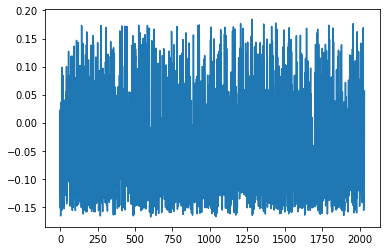

In [110]:
plt.plot(clf.decision_function(KLtr))

In [111]:
# print ('tuning lambda for EasyMKL...', end='')
# base_learner = SVC(C=100)	#simil hard-margin svm
# best_results = {}
# for lam in [0, 0.01, 0.1, 0.2, 0.9, 1]:#possible lambda values for the EasyMKL algorithm
#     #MKLpy.model_selection.cross_val_predict performs the cross validation automatically, it optimizes the accuracy
#     #the counterpart cross_val_score optimized the roc_auc_score (use score='roc_auc')
#     #WARNING: these functions will change in the next version
#     scores = cross_val_predict(KLtr, Ytr, EasyMKL(learner=base_learner, lam=lam), n_folds=5, score='accuracy')
#     acc = np.mean(scores)
# #     if not best_results or best_results['score'] < acc:
# #         best_results = {'lam' : lam, 'score' : acc}